# Comparing Models on a Correct Sample

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to Cuda

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Get Test Data and Sub Labels

In [3]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [4]:
# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

# sub labels
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

In [5]:
def get_sample(idx):
    return test_images[idx], test_labels[idx], test_horizontal_image_labels[idx].reshape(28, 28), test_vertical_image_labels[idx].reshape(28, 28)

In [6]:
img, label, h_edge, v_edge = get_sample(0)

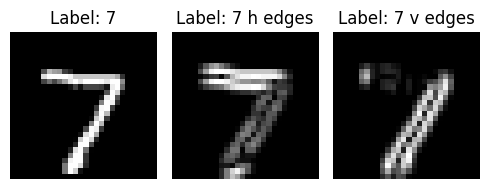

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(5, 5))

visualize_image(img, label, ax=axes[0])
visualize_image(h_edge, f"{label} h edges", ax=axes[1])
visualize_image(v_edge, f"{label} v edges", ax=axes[2])

plt.tight_layout()
plt.show()

## Load Models

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal processing
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical processing
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # classification
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

In [9]:
main_quest_model = NeuralNetwork().to(device)
main_quest_model.load_state_dict(torch.load("./main_quest.pth"))

side_quest_model = NeuralNetwork().to(device)
side_quest_model.load_state_dict(torch.load("./side_quests.pth"))

partial_side_quest_model = NeuralNetwork().to(device)
partial_side_quest_model.load_state_dict(torch.load("./partial_side_quests.pth"))

<All keys matched successfully>

## Comparing Layer Weights Across Models

### Horizontal Weights

In [10]:
main_h_weights = np.abs(main_quest_model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
side_h_weights = np.abs(side_quest_model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
partial_h_weights = np.abs(partial_side_quest_model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

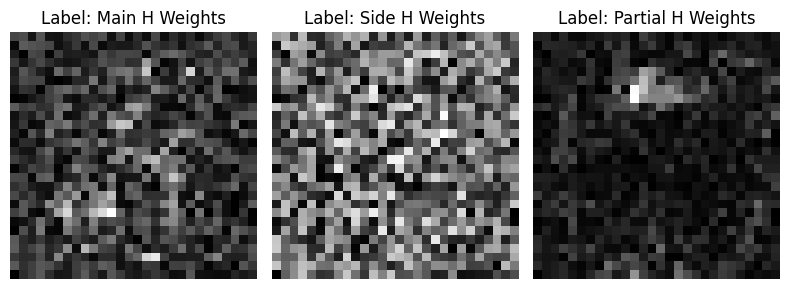

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(main_h_weights, "Main H Weights", ax=axes[0])
visualize_image(side_h_weights, "Side H Weights", ax=axes[1])
visualize_image(partial_h_weights, "Partial H Weights", ax=axes[2])

plt.tight_layout()
plt.show()

### Vertical Weights

In [16]:
main_v_weights = np.abs(main_quest_model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
side_v_weights = np.abs(side_quest_model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
partial_v_weights = np.abs(partial_side_quest_model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

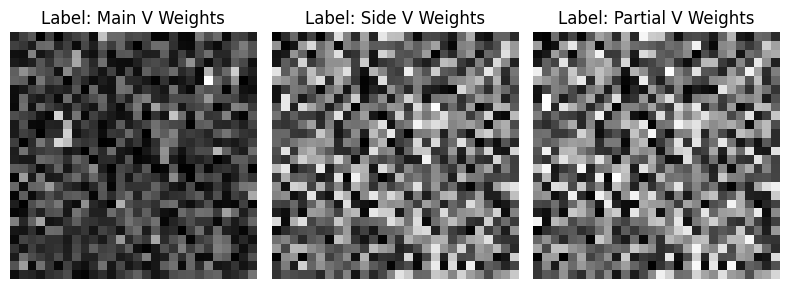

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(main_v_weights, "Main V Weights", ax=axes[0])
visualize_image(side_v_weights, "Side V Weights", ax=axes[1])
visualize_image(partial_v_weights, "Partial V Weights", ax=axes[2])

plt.tight_layout()
plt.show()

### Classifcation Weights

In [18]:
main_c_weights = np.abs(main_quest_model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
side_c_weights = np.abs(side_quest_model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
partial_c_weights = np.abs(partial_side_quest_model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

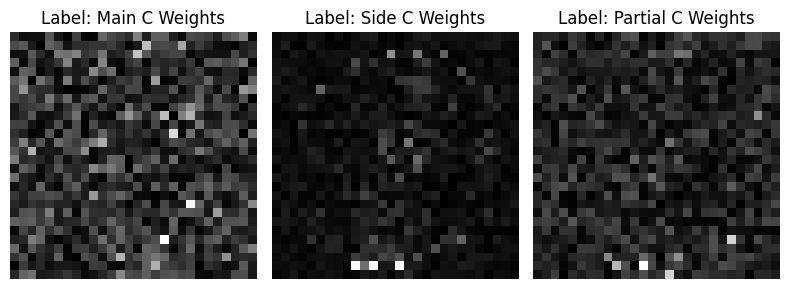

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(main_c_weights, "Main C Weights", ax=axes[0])
visualize_image(side_c_weights, "Side C Weights", ax=axes[1])
visualize_image(partial_c_weights, "Partial C Weights", ax=axes[2])

plt.tight_layout()
plt.show()

### Comparing Layer Weights via MSE

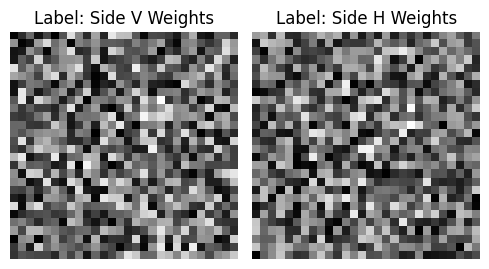

MSE: 0.00024801530526019633


In [61]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

visualize_image(side_v_weights, "Side V Weights", ax=axes[0])
visualize_image(side_h_weights, "Side H Weights", ax=axes[1])

plt.tight_layout()
plt.show()

# mse b/w side vertical weights and side horizontal weights
print(f"MSE: {np.mean((side_v_weights - side_h_weights) ** 2)}")

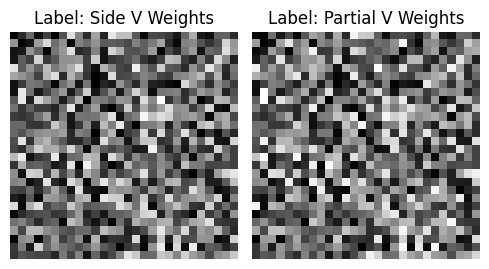

MSE: 6.723363640048774e-06


In [63]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

visualize_image(side_v_weights, "Side V Weights", ax=axes[0])
visualize_image(partial_v_weights, "Partial V Weights", ax=axes[1])

plt.tight_layout()
plt.show()

# mse b/w side vertical layer weights and partial vertical weights
print(f"MSE: {np.mean((side_v_weights - partial_v_weights) ** 2)}")

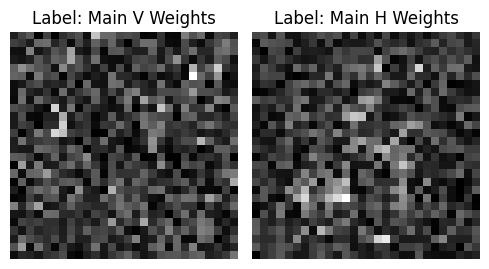

MSE: 0.0004863521608058363


In [65]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

visualize_image(main_v_weights, "Main V Weights", ax=axes[0])
visualize_image(main_h_weights, "Main H Weights", ax=axes[1])

plt.tight_layout()
plt.show()

# mse b/w main vertical and horizontal layer weights
print(f"MSE: {np.mean((main_v_weights - main_h_weights) ** 2)}")

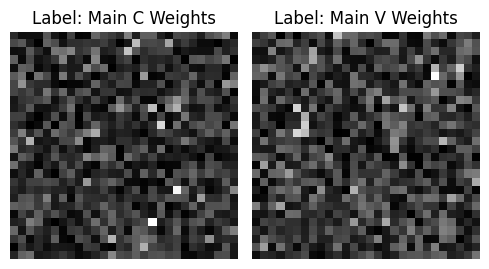

MSE: 0.0003822258731815964


In [66]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

visualize_image(main_c_weights, "Main C Weights", ax=axes[0])
visualize_image(main_v_weights, "Main V Weights", ax=axes[1])

plt.tight_layout()
plt.show()

# mse b/w main output and vertical layer weights
print(f"MSE: {np.mean((main_c_weights - main_v_weights) ** 2)}")

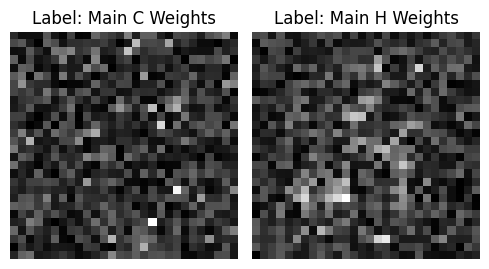

MSE: 0.00045649163075722754


In [67]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

visualize_image(main_c_weights, "Main C Weights", ax=axes[0])
visualize_image(main_h_weights, "Main H Weights", ax=axes[1])

plt.tight_layout()
plt.show()

# mse b/w main output and horizontal layer weights
print(f"MSE: {np.mean((main_c_weights - main_h_weights) ** 2)}")

Using MSE above to confirm suspicions from visuals.

Seems like the learning of patterns is equally shared across the "main quest" model. The "side quest" model appears to learn the majority of information in its vertical and horizontal layers. The "partial quest" model appear to learn almost all of its patterns on the vertical layer, which, interestingly enough appears almost identical to the vertical layer weights of the side quest model.

So, is extra horizontal information bad? Or is it that we have too much information being encoded in the first two layers, and so, the coupling layer doesn't really know what to do? Should we be classifying immediately after the vertical layer, when these intermediate features are partially imposed? Isn't that basically image reconstruction at that point?

## Activation and Sample Exploration

In [30]:
def convert_tensor_to_np_arr(img_tensor):
    return np.abs(img_tensor.clone().reshape(28, 28).detach().cpu().numpy())

In [20]:
def convert_numpy_image_to_tensor(img):
    """
    """
    return torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')

In [24]:
img_tensor = convert_numpy_image_to_tensor(img)

In [32]:
main_quest_model.eval()
side_quest_model.eval()
partial_side_quest_model.eval()
with torch.no_grad():
    out, v_act, h_act = main_quest_model(img_tensor)
    s_out, s_v_act, s_h_act = side_quest_model(img_tensor)
    p_out, p_v_act, p_h_act = partial_side_quest_model(img_tensor)

### Horizontal Activation Example

In [37]:
h_act_img = convert_tensor_to_np_arr(h_act)
s_h_act_img = convert_tensor_to_np_arr(s_h_act)
p_h_act_img = convert_tensor_to_np_arr(p_h_act)

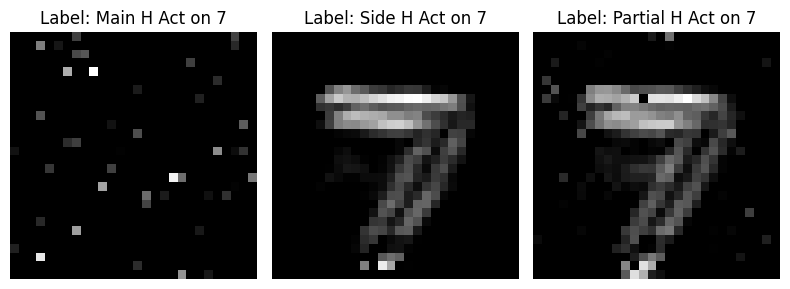

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(h_act_img, f"Main H Act on {label}", ax=axes[0])
visualize_image(s_h_act_img, f"Side H Act on {label}", ax=axes[1])
visualize_image(p_h_act_img, f"Partial H Act on {label}", ax=axes[2])

plt.tight_layout()
plt.show()

### Vertical Activation Example

In [34]:
v_act_img = convert_tensor_to_np_arr(v_act)
s_v_act_img = convert_tensor_to_np_arr(s_v_act)
p_v_act_img = convert_tensor_to_np_arr(p_v_act)

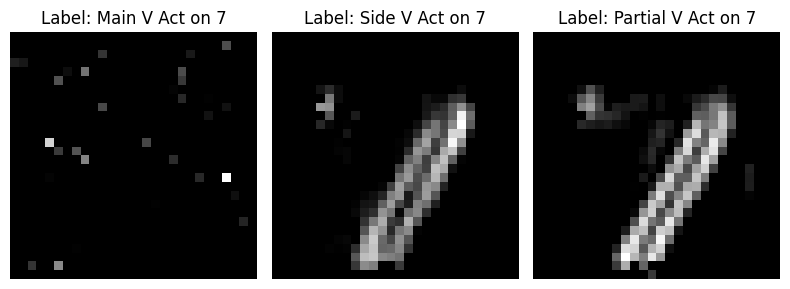

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

visualize_image(v_act_img, f"Main V Act on {label}", ax=axes[0])
visualize_image(s_v_act_img, f"Side V Act on {label}", ax=axes[1])
visualize_image(p_v_act_img, f"Partial V Act on {label}", ax=axes[2])

plt.tight_layout()
plt.show()

In [75]:
print(out)
print(s_out)
print(p_out)

tensor([[ -0.4680,  -6.0393,   3.6817,   2.4772,  -3.5936,   0.2911, -12.5736,
          21.4579, -16.9147,   3.4099]], device='cuda:0')
tensor([[ -95.8572,  -89.0305,   12.7879,  107.8663,   -5.7693,    1.5065,
         -201.4395,  210.5442,   52.7506,  109.5233]], device='cuda:0')
tensor([[-20.3046, -19.2474,  14.3819,  80.7066,  20.6348,  24.5856, -73.3813,
         127.5045,  26.7057,  71.6410]], device='cuda:0')


In [43]:
torch.max(out, 1)[1].item(), torch.max(s_out, 1)[1].item(), torch.max(p_out, 1)[1].item()

(7, 7, 7)

We do see on a correct example that both the side and partial quest models extracted something more resembeling the digit 7, which is what should have been identified. The main quest model is very noisy, and it is hard to make sense what is going on there. Perhaps some feature extraction techniques on this model are needed to try and learn the intermediate features - hopefully there is something to extract and the patterns are not gibberish.